### Checking SMAP datasets

In [ ]:
%pwd

In [86]:
import pandas as pd 
import numpy as np
import geopandas as gp
import seaborn as sns 
import matplotlib.pyplot as plt
from functools import reduce
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import gaussian_kde
import copy


In [2]:
predicted_swd= '/home/ubuntu/gridmet_test_run/test_data_predicted.csv'

In [3]:
testing_data = pd.read_csv("/home/ubuntu/gridmet_test_run/smap_testing.csv")
pre_testing = pd.read_csv(predicted_swd)

In [ ]:
testing_example_date =testing_data[testing_data['date'] ==  '2018-04-15'].copy()
# print(testing_example_date["snow_mass"])
lat = testing_example_date['lat']
lon = testing_example_date['lon']
latlims = [np.min(lat),np.max(lat)]
lonlims = [np.min(lon),np.max(lon)]

fig, ax = plt.subplots()
out = ax.scatter(testing_example_date["lon"],
           testing_example_date["lat"],
           120,c=testing_example_date["snow_depth"],
           marker='s', cmap = "viridis")
ax.set_xlim(lonlims)
ax.set_ylim(latlims)
fig.colorbar(out)

In [ ]:
predicted_data = pd.read_csv("/home/ubuntu/gridmet_test_run/all_merged_training_water_year_winter_month_only_with_no_snow.csv")
predicted_data[["lat", "lon"]] = predicted_data[["lat", "lon"]].astype('float32')

In [ ]:
training = pd.read_csv("/home/ubuntu/gridmet_test_run/smap_training.csv")
training[["lat", "lon"]] = training[["lat", "lon"]].astype('float32')

In [ ]:
corr_hub  = []
for i in training[["lat", "lon"]].drop_duplicates().values.tolist():
    lat = i[0]
    lon = i[1]
    training_i = training[(training["lat"] == lat) &
                         (training["lon"] == lon)]
    site_i = predicted_data[(predicted_data["lat"] == lat) & 
                   (predicted_data["lon"] == lon)]
    data = pd.merge(site_i[["swe_value", "date"]], training_i[["snow_depth", "date"]], on = "date")
    corr = np.corrcoef(data["swe_value"], data["snow_depth"])[0,1]
    corr_hub.append([lat, lon, corr])
corr_hub_pd = pd.DataFrame(corr_hub, columns=["lat", "lon", "corr"])

In [ ]:
lat = corr_hub_pd['lat']
lon = corr_hub_pd['lon']
latlims = [np.min(lat),np.max(lat)]
lonlims = [np.min(lon),np.max(lon)]

fig, ax = plt.subplots()
out = ax.scatter(corr_hub_pd["lon"],
           corr_hub_pd["lat"],
           120,c=corr_hub_pd["corr"],
           marker='s', cmap = "viridis")
ax.set_xlim(lonlims)
ax.set_ylim(latlims)
cbar = fig.colorbar(out)
cbar.set_label('Snow depth (SMAP) vs. SWE')

ax.set_xlabel("Longitude [deg]")
ax.set_ylabel("Latitude [deg]")
fig.savefig("corr.png")

In [27]:
testing_model1 = pd.read_csv("/home/ubuntu/gridmet_test_run/test_data_predicted_RFqdr.csv")
testing_model2 = pd.read_csv("/home/ubuntu/gridmet_test_run/test_data_predicted_04kMV.csv")
testing_model3 = pd.read_csv("/home/ubuntu/gridmet_test_run/test_data_predicted_dvFvz.csv")
testing_model4 = pd.read_csv("/home/ubuntu/gridmet_test_run/test_data_predicted_oaZvR.csv")

In [94]:
corr_hub = []
mi_hub = []
site_inforamtion = testing_data[["lat", "lon"]].drop_duplicates().values.tolist()
for d in np.arange(len(site_inforamtion)):
    
    lat_t = site_inforamtion[d][0] 
    lon_t = site_inforamtion[d][1]
    smap_data = testing_data.loc[(testing_data["lat"] == lat_t) & 
                             (testing_data["lon"] == lon_t), [
                                                              "date", "snow_depth"]].copy()
    
    model1 = testing_model1.loc[(testing_model1["lat"] == lat_t) & 
                  (testing_model1["lon"] == lon_t), 
                               ["date", "predicted_swe"]].copy().rename(columns = {"predicted_swe":"M1"})
    
    model2 = testing_model2.loc[(testing_model2["lat"] == lat_t) & 
                  (testing_model2["lon"] == lon_t),
                               ["date", "predicted_swe"]].copy().rename(columns = {"predicted_swe":"M2"})
    
    model3 = testing_model3.loc[(testing_model3["lat"] == lat_t) & 
                  (testing_model3["lon"] == lon_t),
                               ["date", "predicted_swe"]].copy().rename(columns = {"predicted_swe":"M3"})
    
    model4 = testing_model4.loc[(testing_model4["lat"] == lat_t) & 
                  (testing_model4["lon"] == lon_t),
                               ["date", "predicted_swe"]].copy().rename(columns = {"predicted_swe":"M4"})
    hub = reduce(lambda df_left,df_right: pd.merge(df_left, df_right, 
                                              on = "date" 
                                             ), [smap_data, model1, model2, model3, model4]).drop(columns = ["date"])
    
    corr_hub.append([lat_t, lon_t] + hub.corr()["snow_depth"][1:].tolist())

In [62]:
corr_hub = pd.DataFrame(corr_hub, columns= ["lat", "lon", "Model1", "Model2", "Model3", "Model4"])

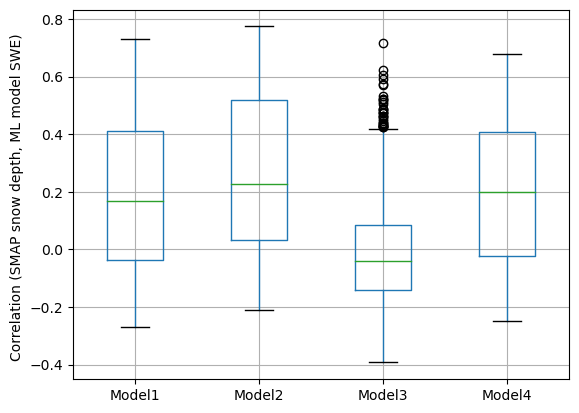

In [71]:
corr_hub.drop(columns=["lat", "lon"]).boxplot()
plt.ylabel("Correlation (SMAP snow depth, ML model SWE) ")
plt.savefig("boxplot.png")

[None, None, None, None]

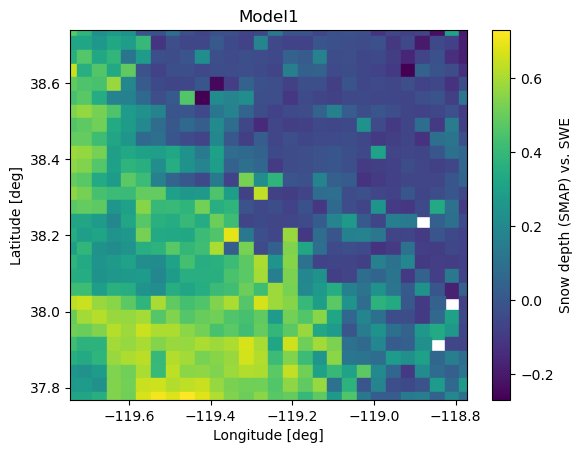

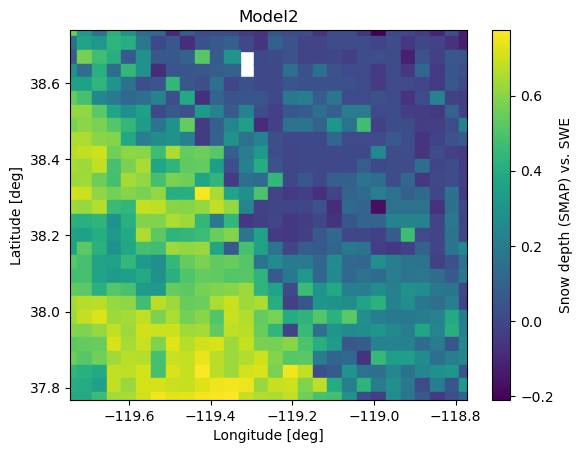

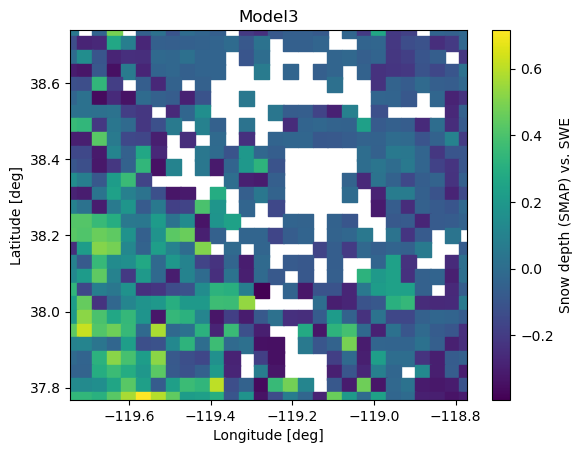

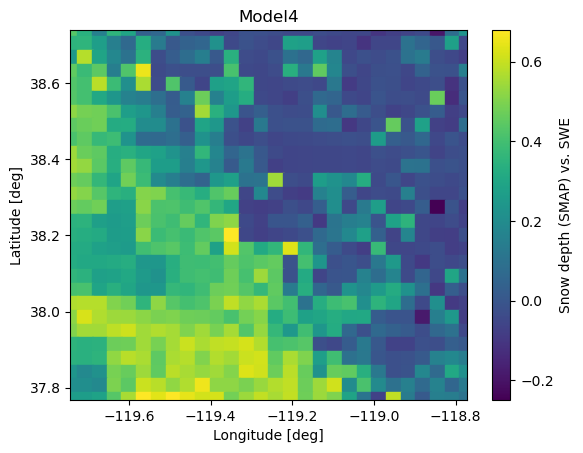

In [66]:
def get_corr(m):

    lat = corr_hub['lat']
    lon = corr_hub['lon']
    latlims = [np.min(lat),np.max(lat)]
    lonlims = [np.min(lon),np.max(lon)]

    fig, ax = plt.subplots()
    out = ax.scatter(corr_hub["lon"],
               corr_hub["lat"],
               120,c=corr_hub[m],
               marker='s', cmap = "viridis")
    ax.set_xlim(lonlims)
    ax.set_ylim(latlims)
    cbar = fig.colorbar(out)
    cbar.set_label('Snow depth (SMAP) vs. SWE')

    ax.set_xlabel("Longitude [deg]")
    ax.set_ylabel("Latitude [deg]")
    ax.set_title(m)
    fig.savefig(f"corr_{m}.png")
[get_corr(f"Model{i}") for i in np.arange(1,5)]
